In [61]:
import ndjson
import numpy as np
from imblearn.under_sampling import RandomUnderSampler

import pandas as pd
from collections import Counter

import altair as alt
# Optional in Jupyter Notebook: requires an up-to-date vega nbextension.
alt.renderers.enable('mimetype')

import random

In [62]:
verified_reviews = []
un_verified_reviews = []

with open("data/Video_Games_5.json", "r") as infile:
    reader = ndjson.reader(infile)
    
    review_dict = {}
    
    for review in reader:
        try:
            review_dict['ratings'] = review["overall"]
            review_dict['reviewText'] = review["reviewText"]
            review_dict['summary'] = review["summary"]
            review_dict['asin'] = review["asin"]
            review_dict['unixReviewTime'] = review["unixReviewTime"]
        except Exception as e:
            continue
    
        # filtering the data set to get reviews with minimum characters
        if len(review_dict['reviewText']) > 3 and len(review_dict['summary'])  > 0:
            
            # Sanitize text
            review_dict['reviewText'] = review_dict['reviewText'].replace('\n', ' ')
            review_dict['summary'] = review_dict['summary'].replace('\n', ' ')
            
            if review['verified'] == True:
                verified_reviews.append(review_dict.copy())
            else:
                un_verified_reviews.append(review_dict.copy())

In [63]:
print(len(verified_reviews))
print(len(un_verified_reviews))

328964
164751


## Save verified and un-verified source data

In [64]:
verified_df = pd.DataFrame(verified_reviews)
with open("data/verified_reviews.tsv", "w") as outfile:
    outfile.write(verified_df.to_csv(index=False, sep="\t"))

In [65]:
un_verified_df = pd.DataFrame(un_verified_reviews)
with open("data/un_verified_reviews.tsv", "w") as outfile:
    outfile.write(un_verified_df.to_csv(index=False, sep="\t"))

## Create a random sampler for creating corpus

## Create corpus of verified reviews

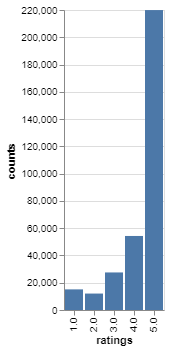

In [66]:
# check ratings distribution
rating_counts = Counter(verified_df['ratings'])
breakout_df = pd.DataFrame(
    {
        "ratings": [str(e) for e in list(rating_counts.keys())],
        "counts": list(rating_counts.values()),
    }
)
alt.Chart(breakout_df).mark_bar().encode(x="ratings", y="counts")

In [67]:
# creating a balanced sampler
# setting up seed as 100
random_sampler = RandomUnderSampler(
    sampling_strategy={1.0: 1000, 2.0: 500, 3.0: 500, 4.0: 1000, 5.0: 1500},
    random_state=100,
)

indices = list(range(len(verified_df)))
indices_sample, ratings_sample = random_sampler.fit_resample(
    np.array(indices).reshape(-1, 1), np.array(verified_df['ratings']).reshape(-1, 1)
)

indices_sample = np.ndarray.flatten(indices_sample)
indices_other = [i for i in list(range(len(verified_df))) if i not in indices_sample]

In [68]:
print(len(indices_sample))
print(len(indices_other))

4500
324464


In [69]:
small_verified_corpus_df = verified_df.iloc[indices_sample]

# setting up seed as 100
# we dont need to to balanced sample as the randomization of bigger chunk will automatically takes care of it
np.random.seed(100)
big_sample_indices = random.sample(indices_other, 100000)
large_verified_corpus_df = verified_df.iloc[big_sample_indices]

## total indices used
used_indices = np.append(big_sample_indices, indices_sample)

## reaining reviews:
reaining_indices =  [i for i in list(range(len(verified_df))) if i not in used_indices]
remaining_df = verified_df.iloc[reaining_indices]

In [70]:
print(len(verified_df))
print(len(small_verified_corpus_df))
print(len(large_verified_corpus_df))
print(len(remaining_df))

328964
4500
100000
224464


In [71]:
with open("data/small_verified_corpus.tsv", "w") as outfile:
    outfile.write(small_verified_corpus_df.to_csv(index=False, sep="\t"))

with open("data/big_verified_corpus.tsv", "w") as outfile:
    outfile.write(large_verified_corpus_df.to_csv(index=False, sep="\t"))

with open("data/remaining_verified_corpus.tsv", "w") as outfile:
    outfile.write(remaining_df.to_csv(index=False, sep="\t"))